# 3D Reconstruction from Single Image using MiDaS and Open3D

This notebook demonstrates a workflow to reconstruct a 3D point cloud from a single 2D image using a pre-trained depth estimation model (MiDaS) and then refine camera intrinsics using least-squares optimization. Finally, the 3D point cloud is visualized and saved using Open3D.

## Table of Contents

1.  [Install Required Libraries](#1.-Install-Required-Libraries)
2.  [Depth Estimation (MiDaS)](#2.-Depth-Estimation-(MiDaS))
3.  [Generate Initial 3D Points](#3.-Generate-Initial-3D-Points)
4.  [Sample Points for Optimization](#4.-Sample-Points-for-Optimization)
5.  [Intrinsic Optimization](#5.-Intrinsic-Optimization)
6.  [Point Cloud Visualization and Saving](#6.-Point-Cloud-Visualization-and-Saving)

<a id="1.-Install-Required-Libraries"></a>
## 1. Install Required Libraries

This step ensures that all necessary Python packages, including `open3d`, `torch`, `torchvision`, `opencv-python`, `numpy`, `scipy`, and `matplotlib`, are installed in the Colab environment. `open3d` is crucial for 3D data processing and visualization.

In [3]:
#Step 1: install related libraries
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


##Download car image

In [5]:
!wget https://github.com/mhsefidgar/3D-Reconstruction/blob/main/SingleImage3DReconstruction/Assets/temerario01.jpg

--2025-12-03 19:24:03--  https://github.com/mhsefidgar/3D-Reconstruction/blob/main/SingleImage3DReconstruction/Assets/temerario01.jpg
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘temerario01.jpg’

temerario01.jpg         [ <=>                ] 182.05K  --.-KB/s    in 0.1s    

2025-12-03 19:24:03 (1.31 MB/s) - ‘temerario01.jpg’ saved [186423]



<a id="2.-Depth-Estimation-(MiDaS)"></a>
## 2. Depth Estimation (MiDaS)

This section uses the MiDaS (Multi-Dataset Augmented Depth Estimation) model to predict the depth map of the input RGB image.

*   A pre-trained `DPT_Large` model is loaded from PyTorch Hub.
*   The input RGB image is preprocessed and fed into the MiDaS model.
*   The output depth map is resized to the original image dimensions and normalized for visualization.
*   The estimated depth map is displayed using `matplotlib`.

In [ ]:
import torch
import torchvision.transforms as T
import cv2
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# -------------------------------
# Step 2: Depth Estimation (MiDaS)
# -------------------------------
model_type = "DPT_Large"  # High quality MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)

transform = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

# Load RGB image
img = cv2.imread(r"/content/temerario01.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_tensor = transform(img_rgb).to(device)
with torch.no_grad():
    depth_map = midas(input_tensor)
    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=img_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
depth_map = depth_map.cpu().numpy()

# Normalize depth for visualization
depth_vis = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
plt.imshow(depth_vis)
plt.title("Estimated Depth")
plt.show()

<a id="3.-Generate-Initial-3D-Points"></a>
## 3. Generate Initial 3D Points

Using the estimated depth map and an initial guess for camera intrinsics (focal length, principal point), this section back-projects the 2D pixels into 3D space to create a preliminary point cloud.

*   `fx0`, `fy0`, `cx0`, `cy0` are initialized as rough estimates for the camera's intrinsic parameters.
*   2D pixel coordinates (`xs`, `ys`) are combined with the depth map (`Z`) to calculate the 3D coordinates (`X`, `Y`, `Z`).

In [ ]:
# -------------------------------
# Step 2: Generate 3D points
# -------------------------------
H, W = depth_map.shape
# Initial guess for intrinsics: focal length = image width, principal point = center
fx0, fy0 = W, H
cx0, cy0 = W/2, H/2

ys, xs = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')
Z = depth_map.flatten()
X = (xs.flatten() - cx0) * Z / fx0
Y = (ys.flatten() - cy0) * Z / fy0

points_3d = np.stack([X, Y, Z], axis=1)
pixels_2d = np.stack([xs.flatten(), ys.flatten()], axis=1)

<a id="4.-Sample-Points-for-Optimization"></a>
## 4. Sample Points for Optimization

To optimize the camera intrinsics more efficiently, a subset of the generated 3D points and their corresponding 2D pixel coordinates are sampled. This reduces the computational cost of the optimization process.

*   Points with zero or near-zero depth are filtered out to avoid division by zero errors during optimization.
*   A fixed number of points (`N_samples`) are randomly selected from the valid points.

In [ ]:
# -------------------------------
# Step 4: Sample points for optimization
# -------------------------------
# Filter out points where Z is zero or very close to zero
valid_indices = Z > 1e-6 # Using a small threshold instead of exact zero
points_3d_filtered = points_3d[valid_indices]
pixels_2d_filtered = pixels_2d[valid_indices]

# To reduce computation, sample 5000 points from the valid points
N_samples = 5000
# Ensure N_samples does not exceed the number of valid points
N_samples = min(N_samples, points_3d_filtered.shape[0])

indices = np.random.choice(points_3d_filtered.shape[0], N_samples, replace=False)
points_3d_sample = points_3d_filtered[indices]
pixels_2d_sample = pixels_2d_filtered[indices]

<a id="5.-Intrinsic-Optimization"></a>
## 5. Intrinsic Optimization

This is a crucial step where the camera's intrinsic parameters (`fx`, `fy`, `cx`, `cy`) are refined using a least-squares optimization approach. The optimization minimizes the reprojection error between the 3D points and their 2D pixel projections.

*   A `reprojection_error` function is defined, which calculates the difference between projected 2D coordinates and actual 2D pixel coordinates.
*   `scipy.optimize.least_squares` is used to find the optimal intrinsic parameters that minimize this error.
*   The optimized intrinsic parameters are then printed.

In [ ]:
# -------------------------------
# Step 5: Intrinsic optimization
# -------------------------------
def reprojection_error(params, points_3d, pixels_2d):
    fx, fy, cx, cy = params
    X, Y, Z = points_3d[:,0], points_3d[:,1], points_3d[:,2]
    u_hat = fx * X / Z + cx
    v_hat = fy * Y / Z + cy
    return np.concatenate([u_hat - pixels_2d[:,0], v_hat - pixels_2d[:,1]])

# Initial guess
params0 = [fx0, fy0, cx0, cy0]

res = least_squares(reprojection_error, params0, args=(points_3d_sample, pixels_2d_sample))
fx_opt, fy_opt, cx_opt, cy_opt = res.x

print("Optimized Intrinsics:")
print("fx:", fx_opt, "fy:", fy_opt, "cx:", cx_opt, "cy:", cy_opt)

<a id="6.-Point-Cloud-Visualization-and-Saving"></a>
## 6. Point Cloud Visualization and Saving

Finally, the full 3D point cloud is reconstructed using the optimized intrinsic parameters and the original RGB image colors. The point cloud is then prepared for visualization and saved to a `.ply` file.

*   The `open3d` library is used to create and manipulate the point cloud object.
*   The 3D points are calculated using the optimized intrinsics, and colors are taken from the original RGB image.
*   The point cloud is transformed (flipped along Y and Z axes) for standard visualization orientation.
*   The point cloud is saved as an `optimized_point_cloud.ply` file, which can be viewed in external 3D viewers.

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


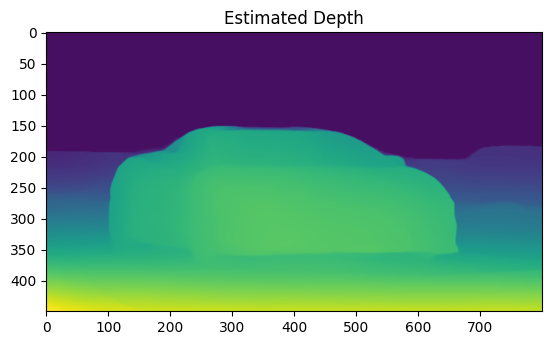

Optimized Intrinsics:
fx: 800.0 fy: 450.0 cx: 400.0 cy: 225.0
[Open3D WARNING] GLFW Error: Failed to detect any supported platform
[Open3D WARNING] GLFW initialized for headless rendering.
[Open3D WARNING] GLFW Error: OSMesa: Library not found
[Open3D WARNING] Failed to create window
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [1]:


# -------------------------------
# Step 5: Optional Point Cloud Visualization
# -------------------------------
import open3d as o3d

# Convert full depth map to 3D points using optimized intrinsics
X_full = (xs - cx_opt) * depth_map / fx_opt
Y_full = (ys - cy_opt) * depth_map / fy_opt
Z_full = depth_map

points_full = np.stack([X_full.flatten(), Y_full.flatten(), Z_full.flatten()], axis=1)
colors = img_rgb.reshape(-1,3)/255.0

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_full)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Flip for visualization
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
o3d.visualization.draw_geometries([pcd])

In [6]:
## Recommended Fix: Save the Point Cloud to a File

# Flip for visualization (as in your original code)
pcd.transform([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])

output_filename = "optimized_point_cloud.ply"
o3d.io.write_point_cloud(output_filename, pcd)

print(f"\n✅ Success! Point cloud saved to: {output_filename}")
print("Please download this file and view it using a 3D viewer (e.g., MeshLab, Open3D application) on your local machine.")

# Optional: Add Colab download code
# from google.colab import files
# files.download(output_filename)


✅ Success! Point cloud saved to: optimized_point_cloud.ply
Please download this file and view it using a 3D viewer (e.g., MeshLab, Open3D application) on your local machine.
